In [ ]:
import numpy as np
import soundfile as sf
from scipy.interpolate import interp1d
import pandas as pd
from scipy.fft import rfft, irfft, rfftfreq
from scipy.signal import welch
import matplotlib.pyplot as plt
import os
import gc
import glob

# Paths
base_path = "C:/Users/Valer/OneDrive/ODL Hydrophone/ODL Recordings/"
output_csv_folder = "C:/Users/Valer/OneDrive/ODL Hydrophone/Data Sheets/PSD Sheets/"
output_fig_psd_folder = "C:/Users/Valer/OneDrive/ODL Hydrophone/Data Sheets/PSD Figures/"
calib_csv_path = "C:/Users/Valer/OneDrive/ODL Hydrophone/Data Sheets/Bins Data for Hydrophone Sensitivity.csv"

# Make sure output folders exist
os.makedirs(output_csv_folder, exist_ok=True)
os.makedirs(output_fig_psd_folder, exist_ok=True)

# Load calibration data
calib_df = pd.read_csv(calib_csv_path)
freq_calib = calib_df["Frequency (Hz)"].to_numpy()
sens_calib = calib_df["Sensitivity (dB re 1V/1uPa)"].to_numpy()
sens_calib_gain = sens_calib + 25.0

# Process WAV files
for filename in os.listdir(base_path):
    if filename.lower().endswith(".wav"):
        output_filename = f"psd_output_{os.path.splitext(filename)[0]}.csv"
        output_path = os.path.join(output_csv_folder, output_filename)
        if os.path.exists(output_path):
            print(f" Skipping already processed file: {filename}")
            continue

        print(f"Processing: {filename}")
        wav_path = os.path.join(base_path, filename)
        signal_raw, fs = sf.read(wav_path)
        # Welch PSD from raw signal
        L = 65536
        n_overlap = int(L * 0.5)
        freqs_psd, psd = welch(signal_raw, fs=fs, window='hann', nperseg=L,
                               noverlap=n_overlap, nfft=L, scaling='density')

        # Interpolate calibration at PSD frequencies
        interp_func = interp1d(freq_calib, sens_calib_gain, kind='linear', fill_value='extrapolate')
        sens_interp_dB = interp_func(freqs_psd)

        # Apply power correction: dB → linear → apply → dB
        gain_correction = 10 ** (-sens_interp_dB / 10)  # power correction
        psd_corrected = psd * gain_correction
        psd_corrected = np.clip(psd_corrected, 1e-12, None)  # avoid log(0)
        psd_dB = 10 * np.log10(psd_corrected)

        # Save PSD CSV
        df_psd_db = pd.DataFrame({
            "Frequency (Hz)": freqs_psd,
            "PSD (dB re 1 µPa²/Hz)": psd_dB
        })
        df_psd_db.to_csv(output_path, index=False)
        print(f" PSD saved to: {output_path}")

        # Plot and save PSD
        fig_psd, ax_psd = plt.subplots(figsize=(12, 6))
        ax_psd.semilogx(freqs_psd, psd_dB)
        ax_psd.set_title(f"PSD of {filename}")
        ax_psd.set_xlabel("Frequency (Hz)")
        ax_psd.set_ylabel("PSD (dB re 1 µPa²/Hz)")
        ax_psd.grid(True, which='both', linestyle='--')
        ax_psd.set_xlim(1, fs / 2)
        plt.tight_layout()

        psd_plot_name = f"psd_{os.path.splitext(filename)[0]}.png"
        psd_plot_path = os.path.join(output_fig_psd_folder, psd_plot_name)
        plt.savefig(psd_plot_path)
        plt.close()
        gc.collect()  # free memory of RAM (use it to handle the situation that it kept crashing)
        print(f"PSD plot saved to: {psd_plot_path}\n")

        # Free memory (troubleshooting ram issue)
        del signal_raw, psd_dB, psd, df_psd_db
        del fig_psd, ax_psd


In [ ]:
# Combine all separate PSD into one CSV (THE MASTER PSD HIHI)
all_psd_csvs = glob.glob(os.path.join(output_csv_folder, "psd_output_*.csv"))
df_all_psds = pd.DataFrame()

for csv_file in all_psd_csvs:
    df_psd = pd.read_csv(csv_file)
    recording_id = os.path.splitext(os.path.basename(csv_file))[0].replace("psd_output_", "")
    df_psd_renamed = df_psd.rename(columns={"PSD (dB re 1 µPa²/Hz)": f"PSD_{recording_id} (dB)"})
    
    if df_all_psds.empty:
        df_all_psds = df_psd_renamed
    else:
        df_all_psds = pd.merge(df_all_psds, df_psd_renamed, on="Frequency (Hz)", how="outer")

# Save combined master CSV
combined_csv_path = os.path.join(output_csv_folder, "ALL_PSDs_combined.csv")
df_all_psds.to_csv(combined_csv_path, index=False)
print(f"Combined all PSDs into: {combined_csv_path}")


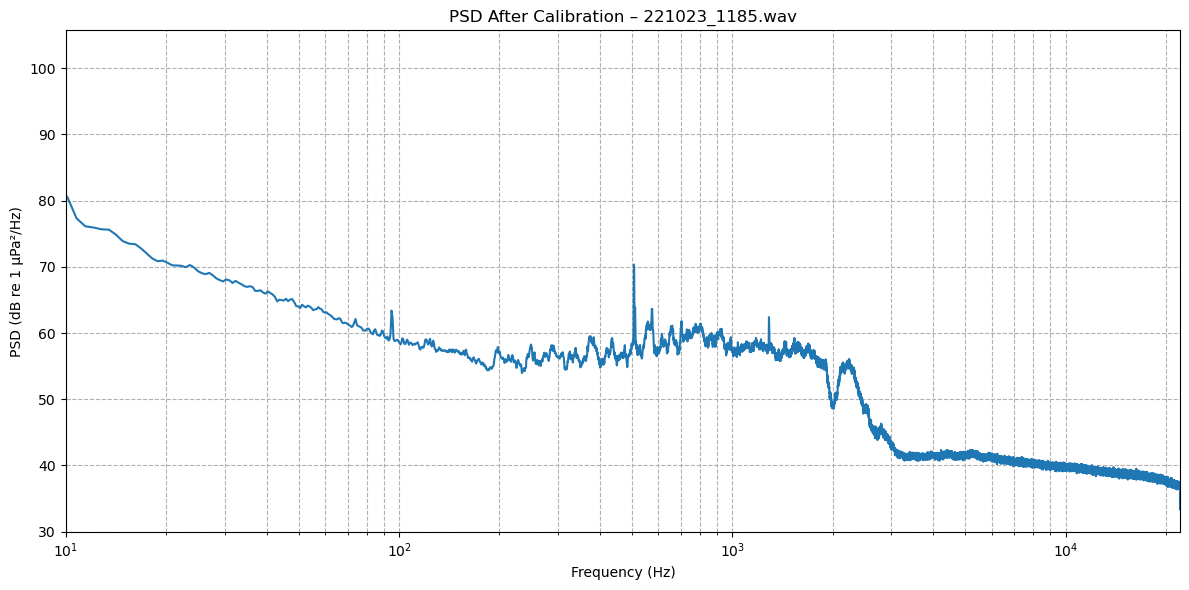

In [7]:
import os
import soundfile as sf
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import welch
import matplotlib.pyplot as plt
import pandas as pd

# Set paths
base_path = "C:/Users/Valer/OneDrive/ODL Hydrophone/ODL Recordings/"
calib_csv_path = "C:/Users/Valer/OneDrive/ODL Hydrophone/Data Sheets/Bins Data for Hydrophone Sensitivity.csv"
test_filename = "221023_1185.wav"

# Load calibration data
calib_df = pd.read_csv(calib_csv_path)
freq_calib = calib_df["Frequency (Hz)"].to_numpy()
sens_calib = calib_df["Sensitivity (dB re 1V/1uPa)"].to_numpy()
sens_calib_gain = sens_calib + 25.0

# Read WAV file
wav_path = os.path.join(base_path, test_filename)
signal_raw, fs = sf.read(wav_path)

# PSD parameters
L = 65536
n_overlap = int(L * 0.5)

# Compute PSD
freqs_psd, psd = welch(signal_raw, fs=fs, window='hann',
                       nperseg=L, noverlap=n_overlap, nfft=L, scaling='density')

# Interpolate sensitivity and apply correction
interp_func = interp1d(freq_calib, sens_calib_gain, kind='linear', fill_value='extrapolate')
sens_interp_dB = interp_func(freqs_psd)
gain_correction = 10 ** (-sens_interp_dB / 10)
psd_corrected = psd * gain_correction
psd_corrected = np.clip(psd_corrected, 1e-12, None)
psd_dB = 10 * np.log10(psd_corrected)

# Plot PSD
plt.figure(figsize=(12, 6))
plt.semilogx(freqs_psd, psd_dB)
plt.title(f"PSD After Calibration – {test_filename}")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD (dB re 1 µPa²/Hz)")
plt.grid(True, which='both', linestyle='--')
plt.xlim(10, fs / 2)
plt.tight_layout()
plt.show()
